In [1]:
import numpy as np
import os

from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt    
import networkx as nx
import copy
from scipy import stats
from copy import deepcopy
import time

import louvain
import leidenalg
import igraph as ig

/home/karan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  del sys.path[0]


In [2]:
A_directed = np.load("adjacency_synaptic_cleft_5.000um.npy")

In [2]:
neuron_names = pd.read_csv("neuron_names.txt", header=None).iloc[:,0].tolist()

# Directed

In [4]:
def get_graph_directed(adj_matfile, neuron_namesfile):
    # import the adjacency matrix from text file
    adjacency = np.load(adj_matfile)
    #print("Shape of adjacency matrix:", adjacency.shape)

    # import names of each neuron
    f = open(neuron_namesfile,"r") #opens file with name of "test.txt"
    neuron_names = []
    for line in f:
        neuron_names.append(line[:-1]) #[:-1] because we don't want /n in the end.  
    #print((neuron_names2))
    n_neurons = len(neuron_names)
    #print("Total number of neurons:",n_neurons)
    
    # create node and node attributes which is the name for the graph
    nodes_list = []
    for i in range(len(neuron_names)):
        #node attribute is given by its neuron name
        nodes_list.append((i,{"name":neuron_names[i]}))
    #print(len(nodes_list))

    # creating an edge list from adjacency matrix
    edge_list=[]
    for i in range(len(neuron_names)):
        for j in range(len(neuron_names)):
            if adjacency[i,j]==0: # if there's no weight, let's forget the edge.
                pass
            else:
                edge_list.append( (i,j,{"weight":adjacency[i,j],"Label":"%s - %s"%(neuron_names[i],neuron_names[j])}) )
    # Creating a directed graph from adjacency matrix so that it will be easy to deal using the networkx module

    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    
  
    return G#adjacency, neuron_names, n_neurons, G


In [5]:
%%time
fname = "adjacency_synaptic_cleft_5.000um.npy"

#fname = "./neurites_axonTermials/adjacency_axon25July.txt"#+str(10)+".txt"

G_dir_nx = get_graph_directed(fname, "neuron_names.txt")
GC_dir_nx =  G_dir_nx.subgraph(max(nx.weakly_connected_components(G_dir_nx), key=len))

CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.7 s


In [6]:
%%time
# convert nx graph to igraph
GC_dir_ig = ig.Graph.from_networkx(GC_dir_nx)

CPU times: user 513 ms, sys: 0 ns, total: 513 ms
Wall time: 536 ms


In [39]:
%%time

from concurrent.futures import ProcessPoolExecutor

def communities_loop(args):
    graph, nreps, seed = args
    np.random.seed(seed)
    
    list_communities = []
    while len(list_communities) < nreps:
        dir_leiden = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")
        if np.unique(dir_leiden.membership).size == 9:
            list_communities.append(dir_leiden.membership)

    return list_communities

nloops = 10
seeds = np.random.randint(0, int(1e6), size = nloops)

with ProcessPoolExecutor() as executor:
    parallel_res = executor.map(communities_loop,
                                zip([GC_dir_ig]*nloops,
                                    [10**3]*nloops,
                                    seeds))
list_communities = []
for res in parallel_res:
    [list_communities.append(i) for i in res]

CPU times: user 3.59 s, sys: 240 ms, total: 3.84 s
Wall time: 6min 17s


In [40]:
len(list_communities)

10000

In [41]:
#list_communities = []
#while len(list_communities) < 10**3:
#    dir_leiden = leidenalg.find_partition(GC_dir_ig, leidenalg.ModularityVertexPartition, weights="weight")
#    if np.unique(dir_leiden.membership).size == 9:
#        list_communities.append(dir_leiden.membership)

In [42]:
def find_communities(list_communities, idx_communities):
    comm = []
    for idx in idx_communities:
        comm.append(np.where(np.array(list_communities) == idx)[0])
    return comm

def find_overlap(comm_check, comm_truth):
    overlap = np.zeros((len(comm_truth), len(comm_check)), dtype = np.float64)
    for i, comm_i in enumerate(comm_truth):
        for j, comm_j in enumerate(comm_check):
            overlap[i][j] = np.intersect1d(comm_i, comm_j).size/(comm_i.size + comm_j.size)
    return overlap

def relabel_communities(idx_comm, comm_truth, list_communities, idx_communities):
    old_comm_list = list_communities[idx_comm]
    overlap = find_overlap(find_communities(old_comm_list, idx_communities),
                           comm_truth)
    
    new_idxs = np.argmax(overlap, axis = 0)
    new_comm_list = np.empty(len(old_comm_list))
    
    for idx, old_val in enumerate(old_comm_list):
        new_comm_list[idx] = new_idxs[old_val]
    
    return new_comm_list

In [43]:
idx_communities = np.arange(9)
comm_truth = find_communities(list_communities[0], idx_communities)

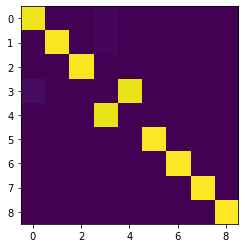

In [44]:
plt.imshow(find_overlap(find_communities(list_communities[443], idx_communities), comm_truth))

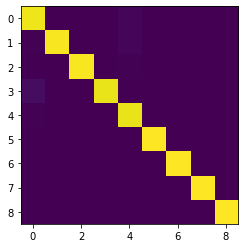

In [45]:
test = relabel_communities(443, comm_truth, list_communities, idx_communities)
plt.imshow(find_overlap(find_communities(test, idx_communities), comm_truth))

In [46]:
%%time

relabeled_comm_list = []
for idx in range(len(list_communities)):
    relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                   list_communities, idx_communities))
    
relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)

CPU times: user 48.2 s, sys: 104 ms, total: 48.3 s
Wall time: 48.3 s


In [47]:
relabeled_comm_list.shape

(10000, 3116)

In [48]:
final_communities = np.empty(relabeled_comm_list.shape[1])
for idx, rep in enumerate(relabeled_comm_list.T):
    final_communities[idx] = np.bincount(rep).argmax()

In [49]:
final_communities

array([1., 1., 1., ..., 1., 1., 0.])

In [50]:
leiden_community_dict = dict(zip(list(GC_dir_ig.vs['_nx_name']), final_communities.astype(np.int8)))

In [ ]:
leiden_community_dict

In [52]:
from matplotlib import patches
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a networkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = plt.figure(figsize=(5, 5)) # in inches
    plt.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    #print(partitions)
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

In [53]:
def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return input_list[int(middle - .5)]
    else:
        return int((input_list[int(middle)] + input_list[int(middle-1)])/2)

In [54]:
from collections import defaultdict

def plot_community_matrix(G_nx, G_ig, louvain_community_dict):

    louvain_comms = defaultdict(list)
    for node_index, comm_id in louvain_community_dict.items():
        louvain_comms[comm_id].append(node_index)
        
    ordered_comm_keys = list(louvain_comms.keys())
    # order_comm_list_values is simply all the members of a community
    mid_point_ticks = [findMiddle(list(order_comm_list_values)) for order_comm_list_values in louvain_comms.values() ]
    
    # partition 0 to N based on community size
    partitioned_list_02N = []
    count=0
    for value in louvain_comms.values():
        sublist = []
        for i in range(len(value)):
            sublist.append(count)
            count+=1
        partitioned_list_02N.append(sublist)
    
    mid_point_ticks = [np.mean(sublist) for sublist in partitioned_list_02N ]
    
    louvain_comms = louvain_comms.values()


    nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]
    draw_adjacency_matrix(G_nx, nodes_louvain_ordered, [louvain_comms], ["blue"])
    
    xticks_comm_name = ordered_comm_keys 
    plt.xticks(mid_point_ticks, xticks_comm_name)
    plt.yticks(mid_point_ticks, xticks_comm_name)

    plt.title("No. of comms: %d"%(len(louvain_comms)))


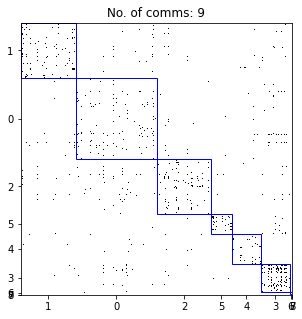

In [55]:
plot_community_matrix(GC_dir_nx, GC_dir_ig, leiden_community_dict)

(array([931., 630., 624., 327., 339., 234.,  27.,   2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

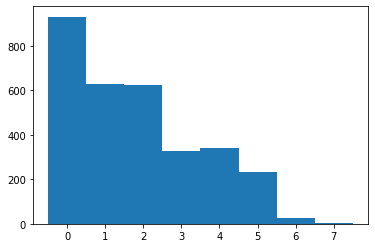

In [56]:
plt.hist(final_communities, bins = np.arange(9)-0.5)

In [32]:
def Community_save(Graph, membership, filename):    
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = membership
    df['Name'] = Graph.vs['name']
    
    df.to_csv(filename+".csv", index=False)

    
    comm_num_list = df["Community"].unique().tolist()
    
    size_list = []
    for comm_num in comm_num_list:
        df_comm = df[df["Community"]==comm_num]
        #df_comm.to_csv(filename+str(comm_num)+".csv", index=False)
        size_list.append(len(df_comm))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(comm_num_list,size_list)
    plt.xlabel("Community", size=15)
    plt.ylabel("Size", size=15)
    plt.title("No. of comm: %d"%len(comm_num_list))
    plt.show()

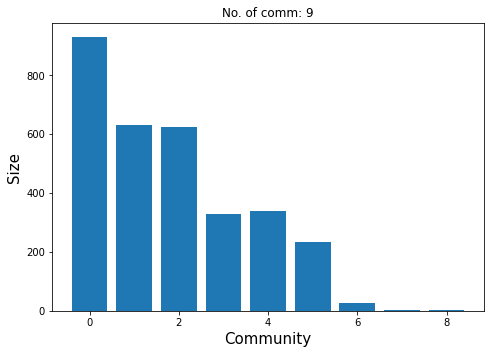

In [63]:
Community_save(GC_dir_ig, final_communities, "averaged_dir_leiden")

In [ ]:
df = pd.read_csv("averaged_dir_leiden.csv")
df

In [ ]:
df.groupby("Community").get_group(1)

# Visualization of the communities

In [3]:

import matplotlib

def plot_community(csv_file, community_file_path, file_name):    
    if not os.path.exists(community_file_path):
        os.makedirs(community_file_path)

    df_all = pd.read_csv(csv_file)
    
    cmt_num = df_all.Community.unique().tolist()
    cmap = matplotlib.cm.get_cmap('tab10')

    colors = [cmap(i)[:3] for i in range(10)]+["yellow", "firebrick"]
    
    for i in cmt_num:
        
        
        df = df_all.groupby("Community").get_group(i)

        community_xyz =[] 
        neuron_names_community = df.Name.tolist()

        file_path = "./strhl_num_1_dataset/"
        for name in neuron_names_community:
            pos_xyz = list(np.loadtxt(file_path+name+".swc")[0,2:5])
            community_xyz.append(pos_xyz)
        community_xyz = np.array(community_xyz)    
        x =  community_xyz[:,0]
        y = community_xyz[:,1] 
        z = community_xyz[:,2]

        plt.figure(figsize=(17,5))
        # Top view
        plt.subplot(1,2,1)       

        plt.scatter(y, x,alpha=0.7,s=20,c = colors[int(i)])        
        plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
        plt.grid(linestyle='--',alpha=0.5,which='both')
        plt.xlabel("Y coordinate",size=16)
        plt.ylabel("X coordinate",size=16)
        plt.title("TOP VIEW",size=18)


        # Side view

        plt.subplot(1,2,2)       

        plt.scatter(y, z,alpha=0.20,s=25,c = colors[int(i)]) 
        plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
        plt.grid(linestyle='--',alpha=0.5,which='both')
        plt.xlabel("Y coordinate",size=16)
        plt.ylabel("Z coordinate",size=16)
        

        plt.savefig(community_file_path+file_name+"_mod"+str(int(i))+'.png', facecolor="white")
        plt.close()
    
    #plt.show()

In [ ]:
plot_community("averaged_dir_leiden.csv","./dir_cmt_anatomical_plots/", "dir_leiden")

In [ ]:
plot_community("averaged_undir_leiden.csv","./undir_cmt_anatomical_plots/", "undir_leiden")

# Average Subcommunities for undirected comm 2 

In [7]:
def get_graph_undirected(adjacency, neuron_namesfile):
    G = nx.from_numpy_matrix(adjacency)#, create_using=nx.MultiGraph)
    f = open(neuron_namesfile,"r") #opens file with name of "test.txt"
    neuron_names = []
    for line in f:
        neuron_names.append(line[:-1]) #[:-1] because we don't want /n in the end.  
        
    nx.set_node_attributes(G, dict(zip(list(G.nodes()),neuron_names)) , "name")    
    return G


In [ ]:
A_undirected = np.load("undirected_adj_synaptic_cleft_5.000 um.npy")

G_undir_nx = get_graph_undirected(A_undirected, "neuron_names.txt")

components = nx.connected_components(G_undir_nx)
lcclist = sorted(list(components), key = len, reverse=True)

GC_undir_nx = nx.subgraph(G_undir_nx, lcclist[0])

GC_undir_ig = ig.Graph.from_networkx(GC_undir_nx)


In [17]:
cmt_num=2
df_all = pd.read_csv("averaged_undir_leiden.csv")

df = df_all.groupby("Community").get_group(cmt_num)

# node numbers of all neurons for a given community
comm_nodes = df.Node.tolist()

delete_nodes = set(range(3163))-set(comm_nodes)

comm_graph = deepcopy(GC_undir_nx)

comm_graph = nx.DiGraph(comm_graph)

comm_graph.remove_nodes_from(  list(delete_nodes) )

GC_subgraph_ig = ig.Graph.from_networkx(comm_graph)


    
    
    

In [19]:
%%time

# no of subcommunities of comm. no. 2 is roughly constant at 5 after investigation. 

#nComm = []
#for i in range(100):
#    subcomm_membership = leidenalg.find_partition(GC_subgraph_ig, leidenalg.ModularityVertexPartition, weights="weight")

#    nComm.append(len(np.unique(subcomm_membership.membership)))
# Counter(nComm)

from concurrent.futures import ProcessPoolExecutor

def communities_loop(args):
    graph, nreps, seed = args
    np.random.seed(seed)
    
    list_communities = []
    while len(list_communities) < nreps:
        dir_leiden = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")
        if np.unique(dir_leiden.membership).size == 5:
            list_communities.append(dir_leiden.membership)

    return list_communities

nloops = 10
seeds = np.random.randint(0, int(1e6), size = nloops)

with ProcessPoolExecutor() as executor:
    parallel_res = executor.map(communities_loop,
                                zip([GC_subgraph_ig]*nloops,
                                    [10**3]*nloops,
                                    seeds))
list_communities = []
for res in parallel_res:
    [list_communities.append(i) for i in res]

CPU times: user 380 ms, sys: 69.1 ms, total: 449 ms
Wall time: 1min 53s


In [20]:
len(list_communities)

10000

In [21]:
def find_communities(list_communities, idx_communities):
    comm = []
    for idx in idx_communities:
        comm.append(np.where(np.array(list_communities) == idx)[0])
    return comm

def find_overlap(comm_check, comm_truth):
    overlap = np.zeros((len(comm_truth), len(comm_check)), dtype = np.float64)
    for i, comm_i in enumerate(comm_truth):
        for j, comm_j in enumerate(comm_check):
            overlap[i][j] = np.intersect1d(comm_i, comm_j).size/(comm_i.size + comm_j.size)
    return overlap

def relabel_communities(idx_comm, comm_truth, list_communities, idx_communities):
    old_comm_list = list_communities[idx_comm]
    overlap = find_overlap(find_communities(old_comm_list, idx_communities),
                           comm_truth)
    
    new_idxs = np.argmax(overlap, axis = 0)
    new_comm_list = np.empty(len(old_comm_list))
    
    for idx, old_val in enumerate(old_comm_list):
        new_comm_list[idx] = new_idxs[old_val]
    
    return new_comm_list

In [22]:
idx_communities = np.array(list(range(5)))
comm_truth = find_communities(list_communities[0], idx_communities)

In [23]:
%%time

relabeled_comm_list = []
for idx in range(len(list_communities)):
    relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                   list_communities, idx_communities))
    
relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)

CPU times: user 9.65 s, sys: 55.1 ms, total: 9.7 s
Wall time: 9.87 s


In [27]:
comm_graph.number_of_nodes()

556

In [24]:
relabeled_comm_list.shape


(10000, 556)

In [28]:

final_communities = np.empty(relabeled_comm_list.shape[1])
for idx, rep in enumerate(relabeled_comm_list.T):
    final_communities[idx] = np.bincount(rep).argmax()
    
leiden_community_dict = dict(zip(list(GC_subgraph_ig.vs['_nx_name']), final_communities.astype(np.int8)))    

In [31]:
def Community_save(Graph, membership, filename):    
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = membership
    df['Name'] = Graph.vs['name']
    
    df.to_csv(filename+".csv", index=False)

    
    comm_num_list = df["Community"].unique().tolist()
    
    size_list = []
    for comm_num in comm_num_list:
        df_comm = df[df["Community"]==comm_num]
        #df_comm.to_csv(filename+str(comm_num)+".csv", index=False)
        size_list.append(len(df_comm))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(comm_num_list,size_list)
    plt.xlabel("Community", size=15)
    plt.ylabel("Size", size=15)
    plt.title("No. of comm: %d"%len(comm_num_list))
    plt.show()

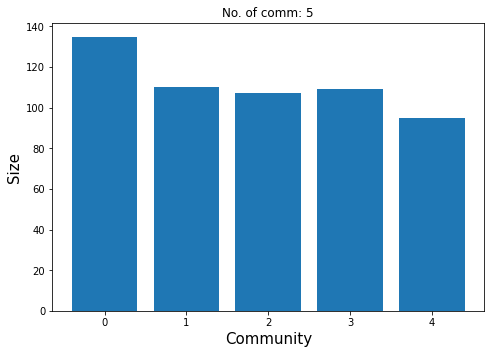

In [33]:
Community_save(GC_subgraph_ig, final_communities, "average_subComm3")

In [36]:

import matplotlib

def plot_community(subcomm_fname):    
    df_all = pd.read_csv(subcomm_fname)
    cmt_num = sorted(df_all.Community.unique().tolist())
    cmap = matplotlib.cm.get_cmap('tab10')

    colors = [cmap(i)[:3] for i in range(10)]+["yellow", "firebrick"]
    
    plt.figure(figsize=(8,5))
        
    for i in cmt_num:
        
        df = df_all.groupby("Community").get_group(i)

        community_xyz =[] 
        neuron_names_community = df.Name.tolist()

        file_path = "./strhl_num_1_dataset/"
        for name in neuron_names_community:
            pos_xyz = list(np.loadtxt(file_path+name+".swc")[0,2:5])
            community_xyz.append(pos_xyz)
        community_xyz = np.array(community_xyz)    
        x =  community_xyz[:,0]
        y = community_xyz[:,1] 
        z = community_xyz[:,2]

        plt.scatter(y, x,alpha=0.7,s=20,c = colors[int(i)], label="sub-comm %d"%i)        
    
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.legend(loc="best")
    plt.grid(linestyle='--',alpha=0.5,which='both')
    plt.xlabel("Y coordinate",size=15)
    plt.ylabel("X coordinate",size=15)
    plt.title( "TOP VIEW, UC%s"%(subcomm_fname[-5] ),size=16)
    plt.savefig('%s.png'%subcomm_fname[:-4], facecolor="white")
    #plt.close()
    
    #plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

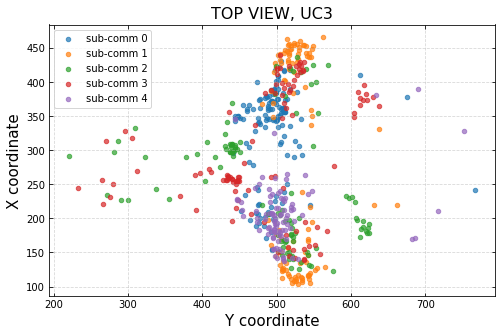

In [37]:
plot_community("average_subComm3.csv")

# Average Subcommunities for undirected comm mod 3 

In [40]:
cmt_num=3
df_all = pd.read_csv("averaged_undir_leiden.csv")

df = df_all.groupby("Community").get_group(cmt_num)

# node numbers of all neurons for a given community
comm_nodes = df.Node.tolist()

delete_nodes = set(range(3163))-set(comm_nodes)

comm_graph = deepcopy(GC_undir_nx)

comm_graph = nx.DiGraph(comm_graph)

comm_graph.remove_nodes_from(  list(delete_nodes) )

GC_subgraph_ig = ig.Graph.from_networkx(comm_graph)


    
    
    

In [39]:
nComm = []
for i in range(100):
    subcomm_membership = leidenalg.find_partition(GC_subgraph_ig, leidenalg.ModularityVertexPartition, weights="weight")

    nComm.append(len(np.unique(subcomm_membership.membership)))
print(Counter(nComm))


Counter({6: 66, 7: 34})


In [41]:
%%time

# no of subcommunities of comm. no. 2 is roughly constant at 6 after investigation. 

#nComm = []
#for i in range(100):
#    subcomm_membership = leidenalg.find_partition(GC_subgraph_ig, leidenalg.ModularityVertexPartition, weights="weight")

#    nComm.append(len(np.unique(subcomm_membership.membership)))
# Counter(nComm)

from concurrent.futures import ProcessPoolExecutor

def communities_loop(args):
    graph, nreps, seed = args
    np.random.seed(seed)
    
    list_communities = []
    while len(list_communities) < nreps:
        dir_leiden = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")
        if np.unique(dir_leiden.membership).size == 6:
            list_communities.append(dir_leiden.membership)

    return list_communities

nloops = 10
seeds = np.random.randint(0, int(1e6), size = nloops)

with ProcessPoolExecutor() as executor:
    parallel_res = executor.map(communities_loop,
                                zip([GC_subgraph_ig]*nloops,
                                    [10**3]*nloops,
                                    seeds))
list_communities = []
for res in parallel_res:
    [list_communities.append(i) for i in res]

CPU times: user 239 ms, sys: 63.9 ms, total: 303 ms
Wall time: 5min 33s


In [43]:
len(list_communities)

10000

In [42]:
def find_communities(list_communities, idx_communities):
    comm = []
    for idx in idx_communities:
        comm.append(np.where(np.array(list_communities) == idx)[0])
    return comm

def find_overlap(comm_check, comm_truth):
    overlap = np.zeros((len(comm_truth), len(comm_check)), dtype = np.float64)
    for i, comm_i in enumerate(comm_truth):
        for j, comm_j in enumerate(comm_check):
            overlap[i][j] = np.intersect1d(comm_i, comm_j).size/(comm_i.size + comm_j.size)
    return overlap

def relabel_communities(idx_comm, comm_truth, list_communities, idx_communities):
    old_comm_list = list_communities[idx_comm]
    overlap = find_overlap(find_communities(old_comm_list, idx_communities),
                           comm_truth)
    
    new_idxs = np.argmax(overlap, axis = 0)
    new_comm_list = np.empty(len(old_comm_list))
    
    for idx, old_val in enumerate(old_comm_list):
        new_comm_list[idx] = new_idxs[old_val]
    
    return new_comm_list

In [44]:
idx_communities = np.array(list(range(6)))
comm_truth = find_communities(list_communities[0], idx_communities)

In [45]:
%%time

relabeled_comm_list = []
for idx in range(len(list_communities)):
    relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                   list_communities, idx_communities))
    
relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)

CPU times: user 11 s, sys: 39.2 ms, total: 11 s
Wall time: 11 s


In [46]:
print(comm_graph.number_of_nodes())
print(relabeled_comm_list.shape)



371
(10000, 371)


In [47]:
final_communities = np.empty(relabeled_comm_list.shape[1])
for idx, rep in enumerate(relabeled_comm_list.T):
    final_communities[idx] = np.bincount(rep).argmax()
    
leiden_community_dict = dict(zip(list(GC_subgraph_ig.vs['_nx_name']), final_communities.astype(np.int8)))    




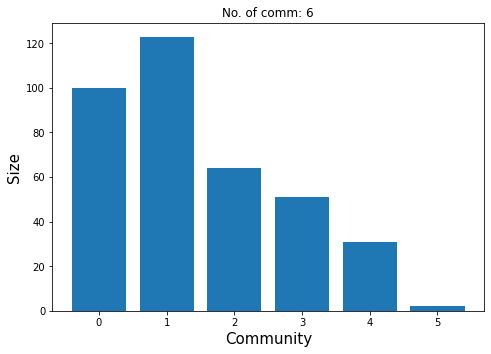

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

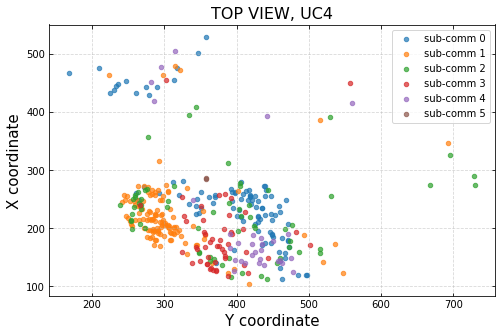

In [48]:
Community_save(GC_subgraph_ig, final_communities, "average_subComm4")

plot_community("average_subComm4.csv")